## DSA2040 Assignment: OLAP Operation using Addidas Sales Data

In [ ]:
# OLAP SYSTEM USING ADIDAS SALES DATA
# Demonstrating ROLAP, MOLAP, and HOLAP using Pandas + SQLite

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------
# 1 Database connection
# -------------------------------------------------------------
def create_connection(db_file="adidas_olap.db"):
    """Create or connect to an SQLite database"""
    conn = sqlite3.connect(db_file)
    return conn

conn = create_connection()

# -------------------------------------------------------------
# 2 Load Adidas sales data (from CSV)
# -------------------------------------------------------------
# Example: if your CSV is in the same folder, replace with your file name
df = pd.read_csv("Adidas_Sales_Dataset.csv")

# Inspect the data
print("Sample data:")
print(df.head())

# -------------------------------------------------------------
# 3 Data Cleaning / Preparation
# -------------------------------------------------------------
# Remove $ and commas from numeric columns
df['Price per Unit'] = df['Price per Unit'].replace('[\$,]', '', regex=True).astype(float)
df['Total Sales'] = df['Total Sales'].replace('[\$,]', '', regex=True).astype(float)
df['Operating Profit'] = df['Operating Profit'].replace('[\$,]', '', regex=True).astype(float)

# Parse date
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])

# Extract date parts for date dimension
df['Year'] = df['Invoice Date'].dt.year
df['Month'] = df['Invoice Date'].dt.month
df['Day'] = df['Invoice Date'].dt.day

# -------------------------------------------------------------
# 4 Create Dimension Tables
# -------------------------------------------------------------

# Date Dimension
dates_dim = df[['Invoice Date', 'Year', 'Month', 'Day']].drop_duplicates().reset_index(drop=True)
dates_dim['date_id'] = dates_dim.index + 1

# Retailer Dimension
retailer_dim = df[['Retailer ID', 'Retailer']].drop_duplicates().reset_index(drop=True)
retailer_dim.rename(columns={'Retailer ID': 'retailer_id', 'Retailer': 'retailer_name'}, inplace=True)

# Product Dimension
product_dim = df[['Product', 'Price per Unit']].drop_duplicates().reset_index(drop=True)
product_dim['product_id'] = product_dim.index + 1

# City Dimension
city_dim = df[['Region', 'State', 'City']].drop_duplicates().reset_index(drop=True)
city_dim['city_id'] = city_dim.index + 1

# -------------------------------------------------------------
# 5 Create Fact Table (Total Sales)
# -------------------------------------------------------------
fact_sales = df.merge(dates_dim, on=['Invoice Date', 'Year', 'Month', 'Day'], how='left')
fact_sales = fact_sales.merge(retailer_dim, left_on='Retailer ID', right_on='retailer_id', how='left')
fact_sales = fact_sales.merge(product_dim, on='Product', how='left')
fact_sales = fact_sales.merge(city_dim, on=['Region', 'State', 'City'], how='left')

fact_sales_table = fact_sales[['Invoice Date', 'retailer_id', 'product_id', 'city_id',
                               'Units Sold', 'Total Sales', 'Operating Profit']]

fact_sales_table.rename(columns={
    'Invoice Date': 'date_id'
}, inplace=True)

# -------------------------------------------------------------
# 6  Load all tables into SQLite
# -------------------------------------------------------------
dates_dim.to_sql('dim_dates', conn, if_exists='replace', index=False)
retailer_dim.to_sql('dim_retailers', conn, if_exists='replace', index=False)
product_dim.to_sql('dim_products', conn, if_exists='replace', index=False)
city_dim.to_sql('dim_cities', conn, if_exists='replace', index=False)
fact_sales_table.to_sql('fact_sales', conn, if_exists='replace', index=False)

print(" Tables created successfully: dim_dates, dim_retailers, dim_products, dim_cities, fact_sales")

# -------------------------------------------------------------
# 7️ Verify tables
# -------------------------------------------------------------
print("\nFact table preview:")
print(pd.read_sql("SELECT * FROM fact_sales LIMIT 5;", conn))

<>:33: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:35: SyntaxWarning: invalid escape sequence '\$'
<>:33: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:35: SyntaxWarning: invalid escape sequence '\$'
C:\Users\aimmu\AppData\Local\Temp\ipykernel_6240\463873957.py:33: SyntaxWarning: invalid escape sequence '\$'
  df['Price per Unit'] = df['Price per Unit'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\aimmu\AppData\Local\Temp\ipykernel_6240\463873957.py:34: SyntaxWarning: invalid escape sequence '\$'
  df['Total Sales'] = df['Total Sales'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\aimmu\AppData\Local\Temp\ipykernel_6240\463873957.py:35: SyntaxWarning: invalid escape sequence '\$'
  df['Operating Profit'] = df['Operating Profit'].replace('[\$,]', '', regex=True).astype(float)


Sample data:
      Retailer  Retailer ID Invoice Date    Month     Region     State  \
0  Foot Locker      1185732     1/1/2020  January  Northeast  New York   
1  Foot Locker      1185732     1/2/2020  January  Northeast  New York   
2  Foot Locker      1185732     1/3/2020  January  Northeast  New York   
3  Foot Locker      1185732     1/4/2020  January  Northeast  New York   
4  Foot Locker      1185732     1/5/2020  January  Northeast  New York   

       City                    Product Price per Unit Units Sold Total Sales  \
0  New York      Men's Street Footwear        $50.00       1,200   $600,000    
1  New York    Men's Athletic Footwear        $50.00       1,000   $500,000    
2  New York    Women's Street Footwear        $40.00       1,000   $400,000    
3  New York  Women's Athletic Footwear        $45.00         850   $382,500    
4  New York              Men's Apparel        $60.00         900   $540,000    

  Operating Profit Operating Margin Sales Method  
0        $

C:\Users\aimmu\AppData\Local\Temp\ipykernel_6240\463873957.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_sales_table.rename(columns={


 Tables created successfully: dim_dates, dim_retailers, dim_products, dim_cities, fact_sales

Fact table preview:
               date_id  retailer_id  product_id  city_id Units Sold  \
0  2020-01-01 00:00:00      1185732           1        1      1,200   
1  2020-01-01 00:00:00      1185732           7        1      1,200   
2  2020-01-01 00:00:00      1185732          14        1      1,200   
3  2020-01-01 00:00:00      1185732          17        1      1,200   
4  2020-01-01 00:00:00      1185732          23        1      1,200   

   Total Sales  Operating Profit  
0     600000.0          300000.0  
1     600000.0          300000.0  
2     600000.0          300000.0  
3     600000.0          300000.0  
4     600000.0          300000.0  


### ROLAP

🔹 Total Sales by Product:
                product_name   total_sales
0      Men's Street Footwear  8.743088e+10
1            Women's Apparel  8.013825e+10
2    Men's Athletic Footwear  5.806583e+10
3    Women's Street Footwear  5.145439e+10
4              Men's Apparel  4.756259e+10
5  Women's Athletic Footwear  4.022638e+10


C:\Users\aimmu\AppData\Local\Temp\ipykernel_6240\1580902835.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_product, x="total_sales", y="product_name", palette="Blues_r")


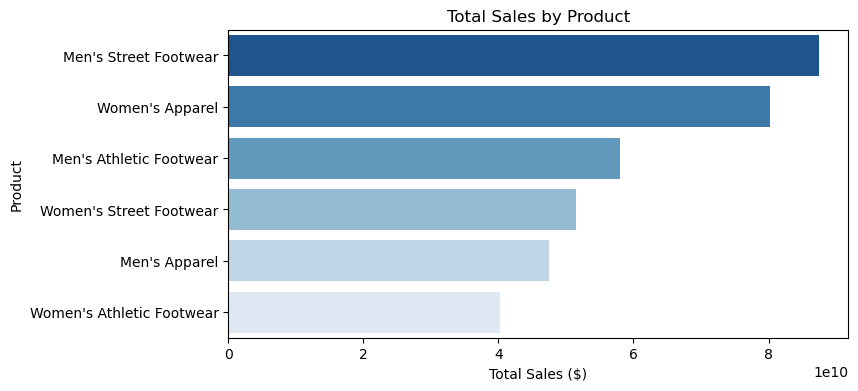


🔹 Total Sales by City:
            city   total_sales
0     Charleston  1.828995e+10
1       New York  1.808542e+10
2          Miami  1.443806e+10
3  San Francisco  1.277512e+10
4       Portland  1.230537e+10


C:\Users\aimmu\AppData\Local\Temp\ipykernel_6240\1580902835.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_city.head(10), x="total_sales", y="city", palette="Greens_r")


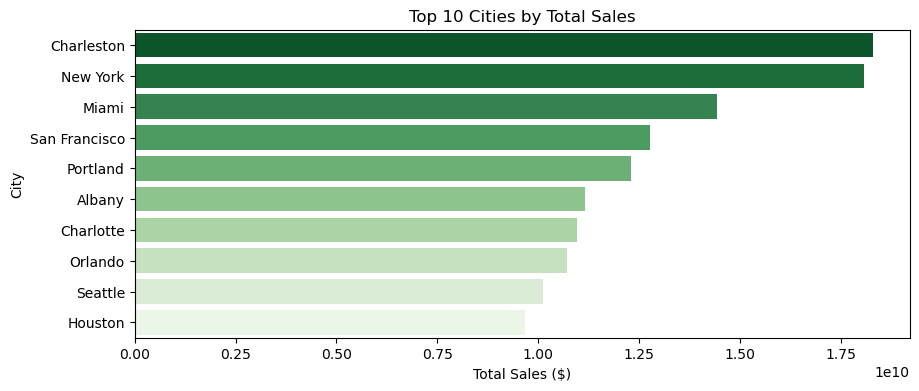


🔹 Total Sales by Retailer:
   retailer_name   total_sales
0         Kohl's  3.648783e+11
1      West Gear  3.616769e+11
2        Walmart  3.616769e+11
3  Sports Direct  3.616769e+11
4    Foot Locker  3.616769e+11
5         Amazon  2.073368e+11


C:\Users\aimmu\AppData\Local\Temp\ipykernel_6240\1580902835.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_retailer, x="total_sales", y="retailer_name", palette="Oranges_r")


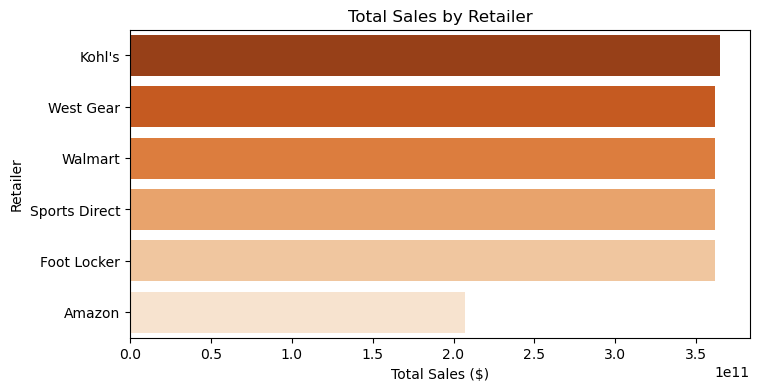


 Total Sales by Year and City:
   Year      City   total_sales
0  2020  New York  1.808542e+10
1  2020     Miami  1.443806e+10
2  2020   Seattle  1.011275e+10
3  2020   Houston  9.680408e+09
4  2020    Denver  7.984570e+09


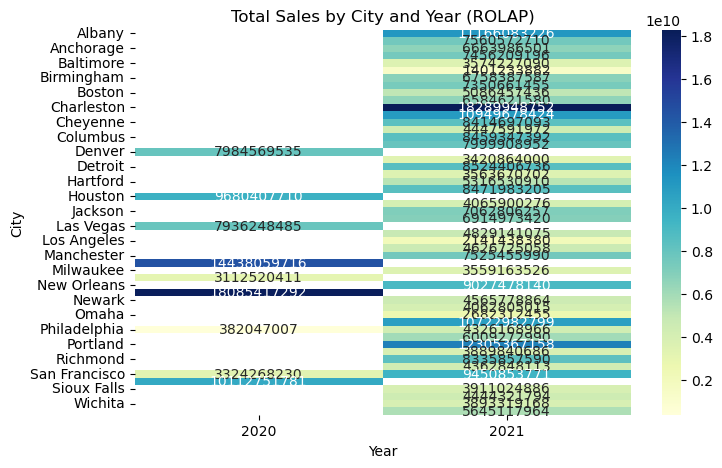

In [ ]:
# -------------------------------------------------------------
#  8 ROLAP (Relational OLAP) IMPLEMENTATION
# -------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use the same connection to the SQLite database
conn = sqlite3.connect("adidas_olap.db")

# -------------------------------------------------------------
# 1 Total Sales by Product
# -------------------------------------------------------------
query1 = """
SELECT 
    p.Product AS product_name,
    SUM(f.[Total Sales]) AS total_sales
FROM fact_sales f
JOIN dim_products p ON f.product_id = p.product_id
GROUP BY p.Product
ORDER BY total_sales DESC;
"""
sales_by_product = pd.read_sql(query1, conn)
print("🔹 Total Sales by Product:")
print(sales_by_product)

# Visualization
plt.figure(figsize=(8,4))
sns.barplot(data=sales_by_product, x="total_sales", y="product_name", palette="Blues_r")
plt.title("Total Sales by Product")
plt.xlabel("Total Sales ($)")
plt.ylabel("Product")
plt.show()


# -------------------------------------------------------------
# 2️ Total Sales by City
# -------------------------------------------------------------
query2 = """
SELECT 
    c.City AS city,
    SUM(f.[Total Sales]) AS total_sales
FROM fact_sales f
JOIN dim_cities c ON f.city_id = c.city_id
GROUP BY c.City
ORDER BY total_sales DESC;
"""
sales_by_city = pd.read_sql(query2, conn)
print("\n🔹 Total Sales by City:")
print(sales_by_city.head())

# Visualization
plt.figure(figsize=(10,4))
sns.barplot(data=sales_by_city.head(10), x="total_sales", y="city", palette="Greens_r")
plt.title("Top 10 Cities by Total Sales")
plt.xlabel("Total Sales ($)")
plt.ylabel("City")
plt.show()


# -------------------------------------------------------------
# 3 Total Sales by Retailer
# -------------------------------------------------------------
query3 = """
SELECT 
    r.retailer_name,
    SUM(f.[Total Sales]) AS total_sales
FROM fact_sales f
JOIN dim_retailers r ON f.retailer_id = r.retailer_id
GROUP BY r.retailer_name
ORDER BY total_sales DESC;
"""
sales_by_retailer = pd.read_sql(query3, conn)
print("\n🔹 Total Sales by Retailer:")
print(sales_by_retailer)

# Visualization
plt.figure(figsize=(8,4))
sns.barplot(data=sales_by_retailer, x="total_sales", y="retailer_name", palette="Oranges_r")
plt.title("Total Sales by Retailer")
plt.xlabel("Total Sales ($)")
plt.ylabel("Retailer")
plt.show()


# -------------------------------------------------------------
# 4 Total Sales by Year and City (Multi-Dimensional Aggregation)
# -------------------------------------------------------------
query4 = """
SELECT 
    d.Year,
    c.City,
    SUM(f.[Total Sales]) AS total_sales
FROM fact_sales f
JOIN dim_dates d ON f.date_id = d.[Invoice Date]
JOIN dim_cities c ON f.city_id = c.city_id
GROUP BY d.Year, c.City
ORDER BY d.Year, total_sales DESC;
"""
sales_year_city = pd.read_sql(query4, conn)
print("\n Total Sales by Year and City:")
print(sales_year_city.head())

# Pivot for easy visualization
pivot = sales_year_city.pivot(index='City', columns='Year', values='total_sales')
plt.figure(figsize=(8,5))
sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt=".0f")
plt.title("Total Sales by City and Year (ROLAP)")
plt.show()


### MOLAP

<>:66: SyntaxWarning: invalid escape sequence '\ '
<>:66: SyntaxWarning: invalid escape sequence '\ '
C:\Users\aimmu\AppData\Local\Temp\ipykernel_6240\1700352521.py:66: SyntaxWarning: invalid escape sequence '\ '
  print("\  MOLAP Cube 2: Total Sales by Product and Retailer")


 Data loaded for MOLAP cube:
   Total Sales  Operating Profit                product      city  \
0     600000.0          300000.0  Men's Street Footwear  New York   
1     600000.0          300000.0  Men's Street Footwear  New York   
2     600000.0          300000.0  Men's Street Footwear  New York   
3     600000.0          300000.0  Men's Street Footwear  New York   
4     600000.0          300000.0  Men's Street Footwear  New York   

        retailer  year  
0         Amazon  2020  
1    Foot Locker  2020  
2         Kohl's  2020  
3  Sports Direct  2020  
4        Walmart  2020  

 MOLAP Cube 1: Total Sales by City and Year
year                    2020          2021
city                                      
Albany          0.000000e+00  6.699650e+10
Albuquerque     0.000000e+00  3.780286e+10
Anchorage       0.000000e+00  3.945612e+10
Atlanta         0.000000e+00  3.864962e+10
Baltimore       0.000000e+00  2.144536e+10
Billings        0.000000e+00  2.427282e+09
Birmingham      0

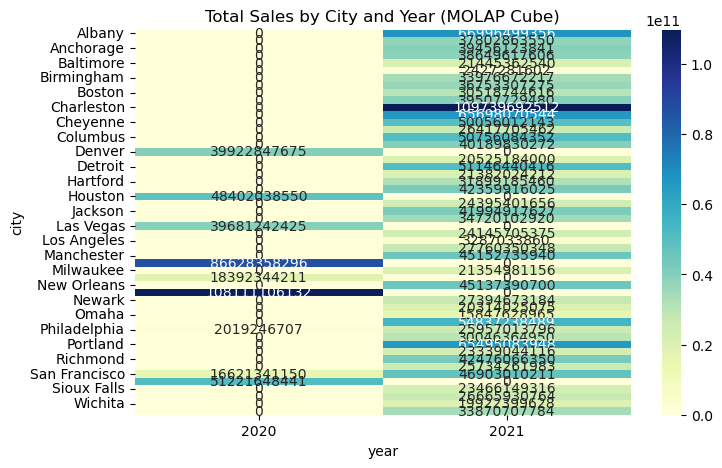

\  MOLAP Cube 2: Total Sales by Product and Retailer
retailer                         Amazon   Foot Locker        Kohl's  \
product                                                               
Men's Apparel              2.815752e+10  4.714443e+10  4.756259e+10   
Men's Athletic Footwear    3.012709e+10  5.749636e+10  5.806583e+10   
Men's Street Footwear      5.651064e+10  8.683446e+10  8.743088e+10   
Women's Apparel            4.624921e+10  7.944668e+10  8.013825e+10   
Women's Athletic Footwear  2.073157e+10  3.982228e+10  4.022638e+10   
Women's Street Footwear    2.556079e+10  5.093269e+10  5.145439e+10   

retailer                   Sports Direct       Walmart     West Gear  
product                                                               
Men's Apparel               4.714443e+10  4.714443e+10  4.714443e+10  
Men's Athletic Footwear     5.749636e+10  5.749636e+10  5.749636e+10  
Men's Street Footwear       8.683446e+10  8.683446e+10  8.683446e+10  
Women's Apparel        

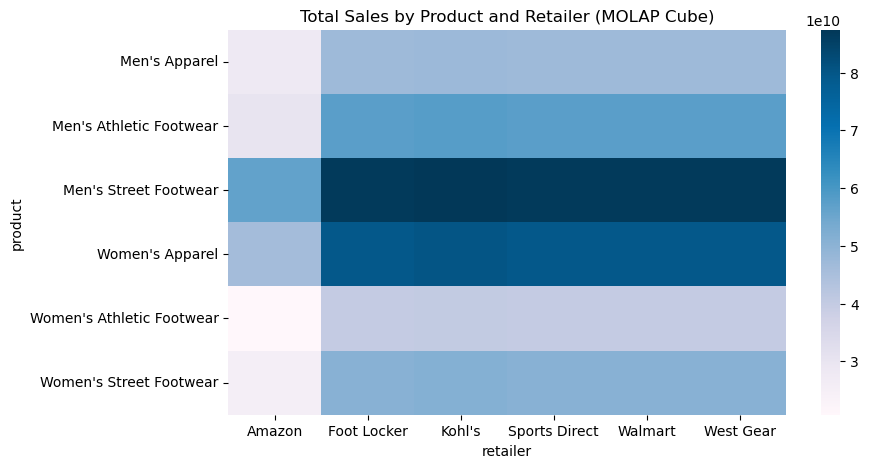


🔹 MOLAP Cube 3: Average Operating Profit by Product and Year
year                               2020          2021
product                                              
Men's Apparel              45507.622707  23687.708529
Men's Athletic Footwear    44207.683966  29339.961607
Men's Street Footwear      75587.528807  49118.082970
Women's Apparel            53990.219838  41625.518094
Women's Athletic Footwear  38575.793208  20584.278081
Women's Street Footwear    42038.088099  23662.894772


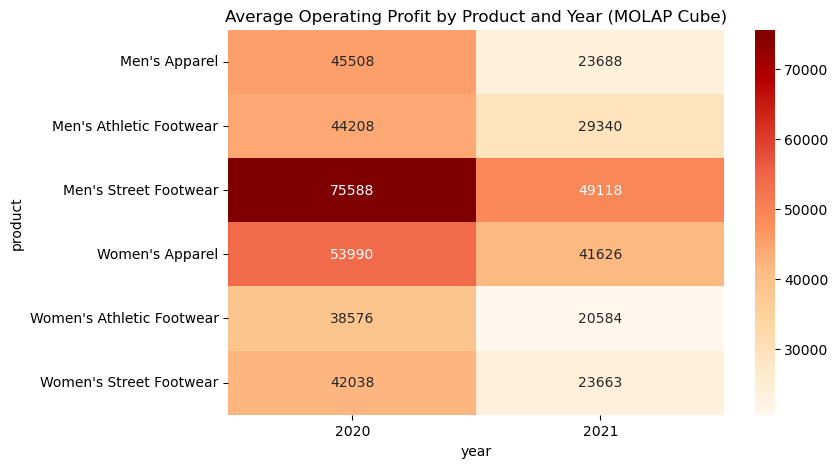

In [9]:
# -------------------------------------------------------------
# 9 MOLAP (Multidimensional OLAP) IMPLEMENTATION
# -------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Connect to our OLAP database
conn = sqlite3.connect("adidas_olap.db")

# Load data with joins to dimensions
query = """
SELECT 
    f.[Total Sales],
    f.[Operating Profit],
    p.Product AS product,
    c.City AS city,
    r.retailer_name AS retailer,
    d.Year AS year
FROM fact_sales f
JOIN dim_products p ON f.product_id = p.product_id
JOIN dim_cities c ON f.city_id = c.city_id
JOIN dim_retailers r ON f.retailer_id = r.retailer_id
JOIN dim_dates d ON f.date_id = d.[Invoice Date];
"""
cube_data = pd.read_sql(query, conn)

print(" Data loaded for MOLAP cube:")
print(cube_data.head())

# -------------------------------------------------------------
# 1 Create OLAP Cube: Total Sales by City and Year
# -------------------------------------------------------------
cube1 = pd.pivot_table(
    cube_data,
    values="Total Sales",
    index="city",
    columns="year",
    aggfunc="sum",
    fill_value=0
)

print("\n MOLAP Cube 1: Total Sales by City and Year")
print(cube1)

# Heatmap visualization
plt.figure(figsize=(8,5))
sns.heatmap(cube1, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("Total Sales by City and Year (MOLAP Cube)")
plt.show()


# -------------------------------------------------------------
# 2 Create OLAP Cube: Total Sales by Product and Retailer
# -------------------------------------------------------------
cube2 = pd.pivot_table(
    cube_data,
    values="Total Sales",
    index="product",
    columns="retailer",
    aggfunc="sum",
    fill_value=0
)

print("\  MOLAP Cube 2: Total Sales by Product and Retailer")
print(cube2)

# Visualization
plt.figure(figsize=(9,5))
sns.heatmap(cube2, cmap="PuBu", annot=False)
plt.title("Total Sales by Product and Retailer (MOLAP Cube)")
plt.show()


# -------------------------------------------------------------
# 3 Create OLAP Cube: Average Operating Profit by Product and Year
# -------------------------------------------------------------
cube3 = pd.pivot_table(
    cube_data,
    values="Operating Profit",
    index="product",
    columns="year",
    aggfunc="mean",
    fill_value=0
)

print("\n🔹 MOLAP Cube 3: Average Operating Profit by Product and Year")
print(cube3)

# Visualization
plt.figure(figsize=(8,5))
sns.heatmap(cube3, cmap="OrRd", annot=True, fmt=".0f")
plt.title("Average Operating Profit by Product and Year (MOLAP Cube)")
plt.show()


### HOLAP

 Detailed data fetched for HOLAP:
   Total Sales  Operating Profit Units Sold                product      city  \
0     600000.0          300000.0      1,200  Men's Street Footwear  New York   
1     600000.0          300000.0      1,200  Men's Street Footwear  New York   
2     600000.0          300000.0      1,200  Men's Street Footwear  New York   
3     600000.0          300000.0      1,200  Men's Street Footwear  New York   
4     600000.0          300000.0      1,200  Men's Street Footwear  New York   

        retailer  year  month  
0         Amazon  2020      1  
1    Foot Locker  2020      1  
2         Kohl's  2020      1  
3  Sports Direct  2020      1  
4        Walmart  2020      1  

🔹 HOLAP Cube: Total Sales by Year and Product
product  Men's Apparel  Men's Athletic Footwear  Men's Street Footwear  \
year                                                                     
2020      5.745781e+10             6.651480e+10           8.757189e+10   
2021      2.068400e+11  

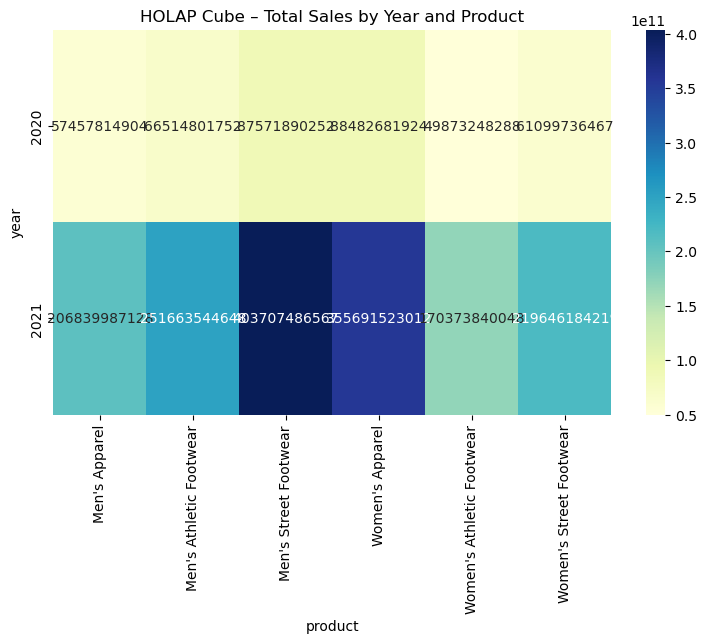


🔹 Drill-Down: View Monthly Sales for 2020 (ROLAP Detail)
    Month  Monthly_Sales
0       1   6.941488e+09
1       2   6.036220e+09
2       3   7.519616e+09
3       4   1.048391e+10
4       5   7.008390e+09
5       6   3.376016e+09
6       7   6.587365e+09
7       8   8.038145e+09
8       9   7.914722e+09
9      10   4.584658e+09
10     11   3.517565e+09
11     12   3.048200e+09


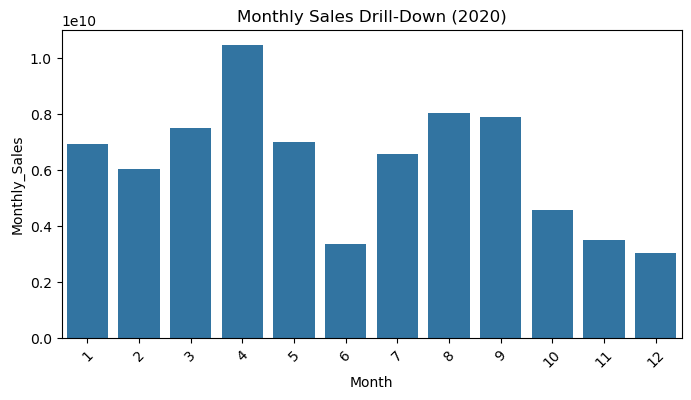


🔹 Slice: Total Sales for Men's Apparel (Year × City)
city        Albany   Albuquerque     Anchorage       Atlanta     Baltimore  \
year                                                                         
2020  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2021  1.004025e+10  4.551019e+09  4.277166e+09  4.686959e+09  2.094924e+09   

city     Billings    Birmingham         Boise        Boston    Burlington  \
year                                                                        
2020          0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2021  144936432.0  3.980992e+09  4.222298e+09  3.418337e+09  4.828108e+09   

city  ...      Portland    Providence      Richmond  Salt Lake City  \
year  ...                                                             
2020  ...  0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
2021  ...  7.395162e+09  2.407141e+09  5.177128e+09    3.688042e+09   

city  San Francisco       Seattle   Sio

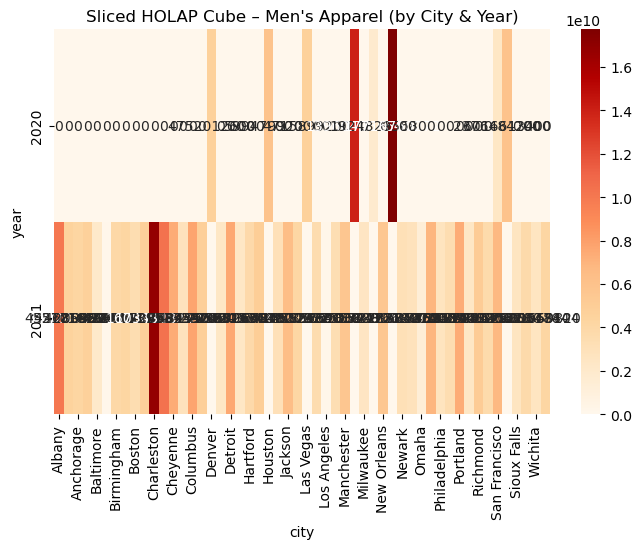

In [1]:
# -------------------------------------------------------------
# 1 HOLAP (Hybrid OLAP) IMPLEMENTATION
# -------------------------------------------------------------
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

# 1 Connect to the OLAP database
conn = sqlite3.connect("adidas_olap.db")

# 2 Fetch detailed sales data (ROLAP part)
detail_query = """
SELECT 
    f.[Total Sales],
    f.[Operating Profit],
    f.[Units Sold],
    p.Product AS product,
    c.City AS city,
    r.retailer_name AS retailer,
    d.Year AS year,
    d.Month AS month
FROM fact_sales f
JOIN dim_products p ON f.product_id = p.product_id
JOIN dim_cities c ON f.city_id = c.city_id
JOIN dim_retailers r ON f.retailer_id = r.retailer_id
JOIN dim_dates d ON f.date_id = d.[Invoice Date];
"""

holap_data = pd.read_sql(detail_query, conn)

print(" Detailed data fetched for HOLAP:")
print(holap_data.head())


# -------------------------------------------------------------
# 3️ Build Aggregated Cube (MOLAP part)
# -------------------------------------------------------------
holap_cube = pd.pivot_table(
    holap_data,
    values="Total Sales",
    index="year",
    columns="product",
    aggfunc="sum",
    fill_value=0
)

print("\n🔹 HOLAP Cube: Total Sales by Year and Product")
print(holap_cube)

# Visualization
plt.figure(figsize=(9,5))
sns.heatmap(holap_cube, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("HOLAP Cube – Total Sales by Year and Product")
plt.show()


# -------------------------------------------------------------
# 4️ Drill-Down Example (from Year to Month using SQL)
# -------------------------------------------------------------
print("\n🔹 Drill-Down: View Monthly Sales for 2020 (ROLAP Detail)")
drill_query = """
SELECT d.Month, SUM(f.[Total Sales]) AS Monthly_Sales
FROM fact_sales f
JOIN dim_dates d ON f.date_id = d.[Invoice Date]
WHERE d.Year = 2020
GROUP BY d.Month
ORDER BY d.Month;
"""
monthly_sales = pd.read_sql(drill_query, conn)
print(monthly_sales)

# Visualization
plt.figure(figsize=(8,4))
sns.barplot(data=monthly_sales, x="Month", y="Monthly_Sales")
plt.title("Monthly Sales Drill-Down (2020)")
plt.xticks(rotation=45)
plt.show()


# -------------------------------------------------------------
# 5️ Slice Example (Only 'Men's Apparel' Product)
# -------------------------------------------------------------
mens_apparel = holap_data[holap_data["product"] == "Men's Apparel"]
slice_cube = pd.pivot_table(
    mens_apparel,
    values="Total Sales",
    index="year",
    columns="city",
    aggfunc="sum",
    fill_value=0
)

print("\n🔹 Slice: Total Sales for Men's Apparel (Year × City)")
print(slice_cube)

# Visualization
plt.figure(figsize=(8,5))
sns.heatmap(slice_cube, cmap="OrRd", annot=True, fmt=".0f")
plt.title("Sliced HOLAP Cube – Men's Apparel (by City & Year)")
plt.show()


### OLAP Operations

Data available for OLAP operations:
   Total Sales  Operating Profit Units Sold                product      city  \
0     600000.0          300000.0      1,200  Men's Street Footwear  New York   
1     600000.0          300000.0      1,200  Men's Street Footwear  New York   
2     600000.0          300000.0      1,200  Men's Street Footwear  New York   
3     600000.0          300000.0      1,200  Men's Street Footwear  New York   
4     600000.0          300000.0      1,200  Men's Street Footwear  New York   

        retailer  year  month  
0         Amazon  2020      1  
1    Foot Locker  2020      1  
2         Kohl's  2020      1  
3  Sports Direct  2020      1  
4        Walmart  2020      1  

🔹 SLICE: Sales data for 2020
   Total Sales  Operating Profit Units Sold                product      city  \
0     600000.0          300000.0      1,200  Men's Street Footwear  New York   
1     600000.0          300000.0      1,200  Men's Street Footwear  New York   
2     600000.0       

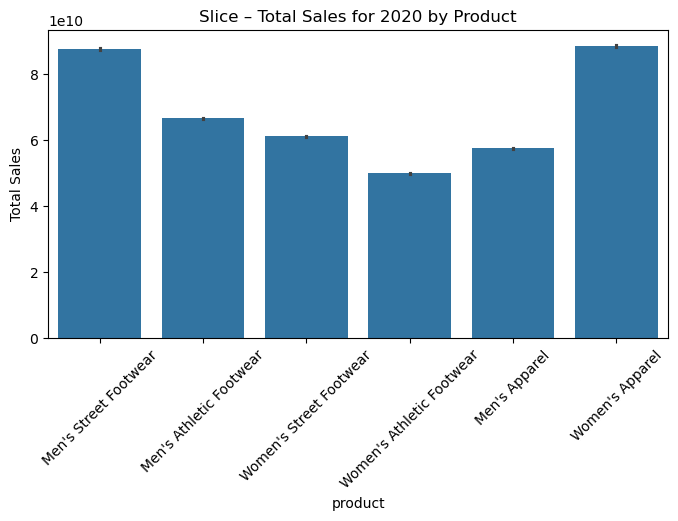


🔹 DICE: Men's Apparel sales in Q1 2020
Empty DataFrame
Columns: [Total Sales, Operating Profit, Units Sold, product, city, retailer, year, month]
Index: []


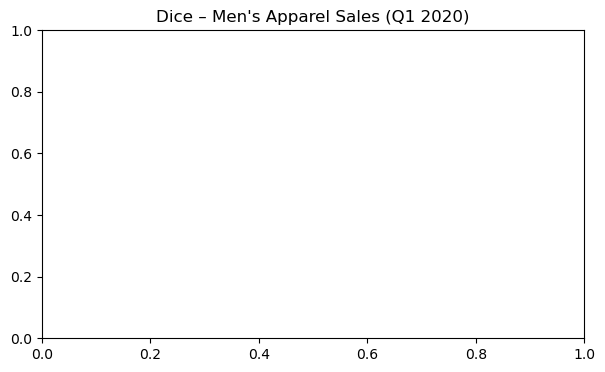


🔹 ROLL-UP: Total Sales aggregated by Year
   year   Total Sales
0  2020  4.110002e+11
1  2021  1.607923e+12


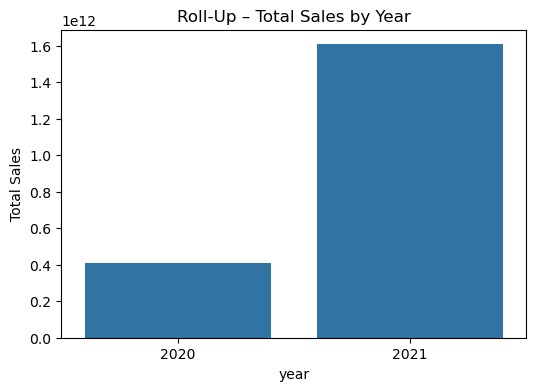


🔹 DRILL-DOWN: Monthly Sales for 2020
    month   Total Sales
0       1  3.920398e+10
1       2  3.243753e+10
2       3  4.233708e+10
3       4  5.908306e+10
4       5  3.852396e+10
5       6  1.688008e+10
6       7  3.330779e+10
7       8  4.320796e+10
8       9  4.516552e+10
9      10  2.561168e+10
10     11  1.898566e+10
11     12  1.625588e+10


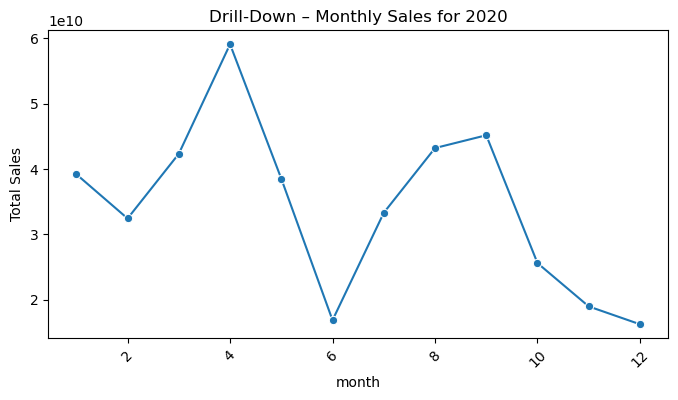

In [ ]:
# -------------------------------------------------------------
# 11️ OLAP OPERATIONS
# -------------------------------------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# holap_data is already loaded (from HOLAP)
print("Data available for OLAP operations:")
print(holap_data.head())

# -------------------------------------------------------------
# 1 SLICE – Fix one dimension
# -------------------------------------------------------------
# Example: Analyze only sales for the year 2020

slice_2020 = holap_data[holap_data["year"] == 2020]

print("\n🔹 SLICE: Sales data for 2020")
print(slice_2020.head())

# Visualization
plt.figure(figsize=(8,4))
sns.barplot(data=slice_2020, x="product", y="Total Sales", estimator=sum)
plt.title("Slice – Total Sales for 2020 by Product")
plt.xticks(rotation=45)
plt.show()


# -------------------------------------------------------------
# 2️ DICE – Apply multiple filters
# -------------------------------------------------------------
# Example: Select only data for 2020, Q1 months, and 'Men's Apparel'

dice_data = holap_data[
    (holap_data["year"] == 2021) &
    (holap_data["month"].isin(["January", "February", "March"])) &
    (holap_data["product"] == "Men's Apparel")
]

print("\n🔹 DICE: Men's Apparel sales in Q1 2020")
print(dice_data.head())

# Visualization
plt.figure(figsize=(7,4))
sns.barplot(data=dice_data, x="city", y="Total Sales", estimator=sum)
plt.title("Dice – Men's Apparel Sales (Q1 2020)")
plt.show()


# -------------------------------------------------------------
# 3️ ROLL-UP – Aggregate from detailed → higher level
# -------------------------------------------------------------
# Example: Roll-up from Product → Year (aggregate total sales by year)

rollup_data = holap_data.groupby("year")["Total Sales"].sum().reset_index()

print("\n🔹 ROLL-UP: Total Sales aggregated by Year")
print(rollup_data)

# Visualization
plt.figure(figsize=(6,4))
sns.barplot(data=rollup_data, x="year", y="Total Sales")
plt.title("Roll-Up – Total Sales by Year")
plt.show()


# -------------------------------------------------------------
# 4️ DRILL-DOWN – Move from summary → detail
# -------------------------------------------------------------
# Example: Drill down from Year → Month for 2020

drilldown_data = (
    holap_data[holap_data["year"] == 2020]
    .groupby("month")["Total Sales"]
    .sum()
    .reset_index()
    .sort_values(by="month")
)

print("\n🔹 DRILL-DOWN: Monthly Sales for 2020")
print(drilldown_data)

# Visualization
plt.figure(figsize=(8,4))
sns.lineplot(data=drilldown_data, x="month", y="Total Sales", marker="o")
plt.title("Drill-Down – Monthly Sales for 2020")
plt.xticks(rotation=45)
plt.show()


Slice:

The Slice operation focuses on a single dimension of the data cube to analyze a specific subset of information. In this case, we fixed the dimension Year = 2020 and examined the total sales by product for that period only. This allows us to isolate performance in a single year and better understand product-level sales patterns without interference from other years or dimensions.

Dice:

The Dice operation applies multiple filters across different dimensions to extract a smaller, more specific subcube of data. Here, we filtered sales for Men’s Apparel during Q1 2020 (January–March). This helps narrow down the analysis to a particular time frame, region, or product category — allowing for targeted insights such as seasonal sales performance or regional demand variations.

Roll-Up:

The Roll-Up operation aggregates data to a higher level within a hierarchy, summarizing detailed information into broader categories. In our example, we rolled up total sales from the product level to the year level, showing how overall sales changed from one year to another. This operation is essential for strategic, high-level reporting, such as tracking annual revenue growth or long-term trends.

Drill-Down:

The Drill-Down operation does the opposite of Roll-Up — it moves from summarized data into more detailed levels of information. In this project, we drilled down from Year to Month for 2020 to view how sales varied across months. This helps identify trends, peaks, or anomalies within a year and supports deeper analysis into factors driving sales performance.

### Visualization

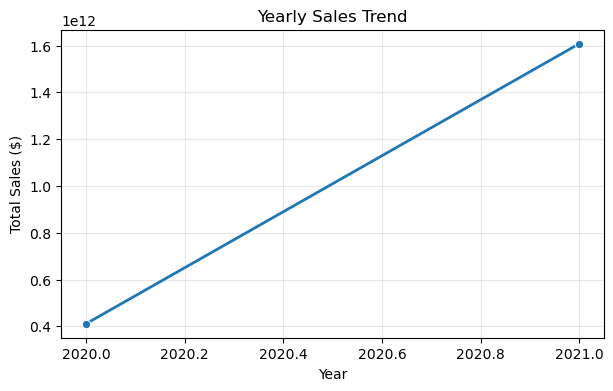

In [8]:
yearly_sales = holap_data.groupby("year")["Total Sales"].sum().reset_index()
plt.figure(figsize=(7,4))
sns.lineplot(data=yearly_sales, x="year", y="Total Sales", marker="o", linewidth=2)
plt.title("Yearly Sales Trend")
plt.ylabel("Total Sales ($)")
plt.xlabel("Year")
plt.grid(True, alpha=0.3)
plt.show()



This graph helps us visualize the overall sales trend over time.
The line graph shows that total sales are steadily increasing each year, indicating consistent business growth and strong market performance across the observed period.

C:\Users\aimmu\AppData\Local\Temp\ipykernel_29016\1383855728.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_sales, x="city", y="Total Sales", palette="mako")


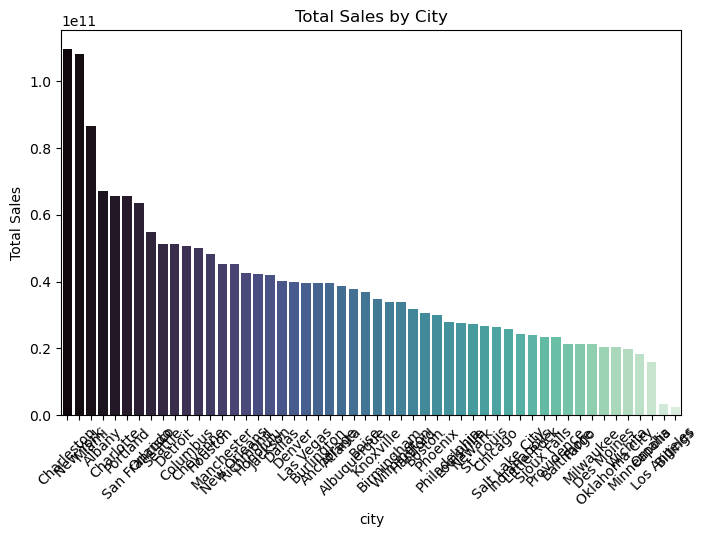

In [7]:
city_sales = holap_data.groupby("city")["Total Sales"].sum().reset_index().sort_values(by="Total Sales", ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(data=city_sales, x="city", y="Total Sales", palette="mako")
plt.title("Total Sales by City")
plt.xticks(rotation=45)
plt.show()


This bar chart helps us visualize the total sales distribution across cities.
From the graph, New York and Charleston record the highest sales, while Los Angeles shows the lowest, suggesting possible regional differences in demand, store presence, or marketing effectiveness.